In [1]:
import os, re, time, json, math
import datetime
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
import pandas as pd
import google
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.1


In [2]:
import tensorflow as tf
import tensorflow.keras as keras

from src.generators.tf_records_generator import DatasetGenerator, count_data_items
from src.models.efficientNet_B0 import EffNet0, freeze_blocks
from src.utils.log_files import save_config, save_fold_iter_history, get_log_dir, save_logs_pickle, generate_columns
from src.utils.kfold import get_kfold_split, get_repeated_kfold_split
from clr_schedule import CyclicLR
from src.utils.schedules import LR_test_schedule
from src.utils.callbacks import CustomStopper

In [3]:
CONFIG = dict(
    log_prefix = "FINAL200_",
    effnet_version = 1,
    image_resolution=384,
    time=datetime.datetime.now().strftime("_%d_%m_%Y_%H_%M"),
    use_patient_data=True,
    inner_blocks_frozen=6,

    upsampling = True,
    upsample_ratio = 5,

    k_fold = 3,
    kfold_repeats = 5,

    patience = 16,
    min_epochs = 32,

    lr_min=0.000003,
    lr_max=0.0001,
    lr_decay=None,
    clr_step_coefficient = 8,
    
    replicas=8,
    steps_per_epoch=None,
    validation_steps=None,
    batch_size=5,
    epochs=32,
    optimizer='adam',
    loss='binary_crossentropy',
    
    output_bias=np.log([584/32542]),
    weight_for_0 = (1 / 32542)*(32542+584)/2.0,
    weight_for_1 = (1 / 584)*(32542+584)/2.0
)

In [5]:
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  # Authenticates the Colab machine and also the TPU using your
  # credentials so that they can access your private GCS buckets.
  auth.authenticate_user()
  data_dir = 'gs://dataset_files/'
else:
  data_dir = 'dataset/'

In [6]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)
CONFIG["replicas"] = strategy.num_replicas_in_sync


Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [7]:
path = data_dir + str(CONFIG["image_resolution"])
files_train = np.sort(np.array(tf.io.gfile.glob(path + '/train*.tfrec')))
files_test = np.sort(np.array(tf.io.gfile.glob(path + '/test*.tfrec')))


gener = DatasetGenerator(CONFIG)

In [8]:
train_ds = gener.get_dataset(files_train, patient_info=True, upsampling=True, augment=True) 

In [8]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

In [12]:
a = train_ds.as_numpy_iterator()

In [44]:
suma=0
steps = 0
for datas, labels in a:
    suma+= np.sum(labels)
    steps+=1
print(suma)
print(steps)

5807
148


In [13]:
suma0=0
suma1=0
for data,label in ds:
    if label == 1:
        suma1 = suma1+1
    else:
        suma0 = suma0+1

NameError: name 'ds' is not defined

In [136]:
suma1

581

In [9]:
a = iter(train_ds)

In [15]:
image, label= next(a)
label

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 0, 0, 0, 0])>

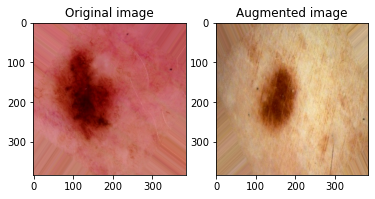

In [17]:
i= 2
visualize(image[0][i],image[0][i+1])

In [26]:
image = image[0][19]

In [42]:
img = tf.image.random_flip_left_right(image)
img = tf.image.random_hue(img, 0.01)
img = tf.image.random_saturation(img, 0.7, 1.3)
img = tf.image.random_contrast(img, 0.8, 1.2)
img = tf.image.random_brightness(img, 0.1)
img = gener.transform(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.92353183
-0.17347991
0.972549
0.003921569


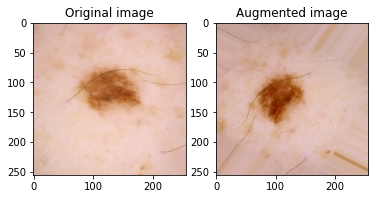

In [43]:
print(np.max(img))
print(np.min(img))
print(np.max(image))
print(np.min(image))

visualize(image, img)

In [4]:
def make_model(config:dict, strategy)    :
    with strategy.scope():
      model = EffNet0(config=config)

      model.compile(optimizer=keras.optimizers.Adam(), loss=config["loss"], 
                    metrics=[
                                  keras.metrics.TruePositives(name='tp'),
                                  keras.metrics.FalsePositives(name='fp'),
                                  keras.metrics.TrueNegatives(name='tn'),
                                  keras.metrics.FalseNegatives(name='fn'), 
                                  keras.metrics.BinaryAccuracy(name='accuracy'),
                                  keras.metrics.Precision(name='precision'),
                                  keras.metrics.Recall(name='recall'),
                                  keras.metrics.AUC(name='auc'),
                            ]
    )
    return model

In [8]:
CONFIG["effnet_version"]=0
model = make_model(CONFIG, strategy)
model.layers[9].summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 384, 384, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 384, 384, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 385, 385, 3)  0           normalization_1[0][0]            
_____________________________________________________________________________________

In [18]:
#kfold_split = get_kfold_split(files_train,CONFIG['k_fold'])
kfold_split = get_repeated_kfold_split(files_train,CONFIG['k_fold'], CONFIG['kfold_repeats'])
save_config(CONFIG)
logs = pd.DataFrame()
log_dir = get_log_dir(CONFIG)
for iter, files in kfold_split.items():
    gener = DatasetGenerator(CONFIG)
    train_ds = gener.get_dataset(files['train'],patient_info=True, upsampling=True, repeat=True,augment=True) 
    val_ds = gener.get_dataset(files['validation'], patient_info=True,repeat=True)
    if CONFIG['steps_per_epoch'] is None:
        CONFIG['steps_per_epoch'] = math.ceil(count_data_items(files["train"])/(CONFIG["batch_size"]*CONFIG["replicas"]))
    if CONFIG['validation_steps'] is None:
       CONFIG['validation_steps'] = math.ceil(count_data_items(files["validation"])/(CONFIG["batch_size"]*CONFIG["replicas"]))

    clr = CyclicLR(base_lr=CONFIG["lr_min"], max_lr=CONFIG["lr_max"],
                                step_size=100*CONFIG['clr_step_coefficient'], mode='triangular')
    stopper = CustomStopper(monitor='val_auc',patience=CONFIG['patience'],start_epoch=CONFIG['min_epochs'])

    model = make_model(CONFIG, strategy=strategy)
    history = model.fit(train_ds,class_weight={0:CONFIG["weight_for_0"],1:CONFIG["weight_for_1"]},
                        validation_data=val_ds,validation_batch_size=CONFIG["batch_size"]*CONFIG["replicas"],
                        batch_size=CONFIG["batch_size"]*CONFIG["replicas"], epochs=CONFIG["epochs"],validation_steps=CONFIG['validation_steps'],
                        callbacks=[clr,stopper])
    
    if logs.empty:
        logs = generate_columns(logs,history.history)
    logs = logs.append(history.history, ignore_index=True)
    
save_logs_pickle(logs,CONFIG)


zip_name = os.path.basename(log_dir) + '.zip'
!zip -r $zip_name $log_dir


Epoch 1/32
    675/Unknown - 38s 57ms/step - loss: 8.5403 - tp: 14.0000 - fp: 110.0000 - tn: 2993.0000 - fn: 258.0000 - accuracy: 0.8910 - precision: 0.1129 - recall: 0.0515 - auc: 0.5791                 

KeyboardInterrupt: 

In [ ]:
print("jacek")

In [ ]:
log_dir = get_log_dir(CONFIG)
zip_name = os.path.basename(log_dir) + '.zip'
!zip -r $zip_name $log_dir

In [ ]:
i = 2
plt.plot(logs['auc'][i])
plt.plot(logs['val_auc'][i])
suma = 0
for k in [0,1,2]:
 suma += np.max(logs['val_auc'][k])
suma/3
np.max(logs['val_auc'][i])